In [ ]:
!pip install shap

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import tensorflow.compat.v1 as tf 
    tf.disable_v2_behavior()
except:
    import tensorflow as tf
    
import os
import h5py
import shap

**Config**

In [18]:
# Dataset specific
input_size = 12
n_clusters = 4
dataset = "WTH"

trans_mat_size = n_clusters 
num_iter = 5
som_dim = [8, 8]
c_len, t_len, out_len = (144, 72, 24)
c_dim = 3
latent_dim = 200
batch_size = 256
lstm_dim = 64
num_pred = out_len
max_n_step = t_len

ex_name = "mirage_2023-09-28-112352_b5347"

In [24]:
datadir = "../data"

def get_data(filename, train_val_split_ratio=0.85):
    """Load the saved data and split into training, validation and test set.
    Args:
        train_val_split_ratio (float): Split of train-validation/test
        filename (str): Name of the data file
    Yields:
        np.array: Training data.
        np.array: Val/test data depending on validation value.
        np.array: Training labels.
        np.array: Val/test data depending on validation value.
    """
    hf = h5py.File(os.path.join(datadir, filename), "r")
    features = np.array(hf.get("x"))
    targets = np.array(hf.get("y"))

    print("data_total shape:", features.shape)
    print("endpoints_total shape", targets.shape)

    len_train = int(len(features) * train_val_split_ratio)

    features_train = features[:len_train]
    targets_train = targets[:len_train]
    features_val = features[len_train:]
    targets_val = targets[len_train:]

    return features_train, features_val, targets_train, targets_val

In [25]:
def batch_generator(data, endpoints, batch_size):
    while True:
        for i in range(len(data) // batch_size):
            time_series_data = data[i * batch_size: (i + 1) * batch_size]
            time_series_endpoint = endpoints[i * batch_size: (i + 1) * batch_size]
            yield time_series_data, time_series_endpoint, i

In [27]:
modelpath = "../models/{}/{}".format(ex_name, ex_name)

data_train, data_val, endpoints_total_train, endpoints_total_val = get_data(
    filename="model_ready_data.h5"
)
(
    data_train_full,
    data_val_full,
    endpoints_total_train_full,
    endpoints_total_val_full,
) = get_data(filename="model_ready_data.h5")

# Truncated to max_n_step time steps only
data_train = data_train[:, :max_n_step, :]
data_val = data_val[:, :max_n_step, :]
endpoints_total_train = endpoints_total_train[:, :max_n_step, :]
endpoints_total_val = endpoints_total_val[:, :max_n_step, :]

data_total shape: (34582, 96, 16)
endpoints_total shape (34582, 96, 5)
data_train shape: (23515, 96, 16)
endpoints_total_train shape (23515, 96, 5)
data_val shape: (5188, 96, 16)
endpoints_total_val shape (5188, 96, 5)
data_total shape: (34582, 96, 16)
endpoints_total shape (34582, 96, 5)
data_train shape: (23515, 96, 16)
endpoints_total_train shape (23515, 96, 5)
data_val shape: (5188, 96, 16)
endpoints_total_val shape (5188, 96, 5)


In [28]:
data_train.shape, data_train_full.shape

((23515, 72, 16), (23515, 96, 16))

In [29]:
train_gen = batch_generator(
    data_train_full, 
    endpoints_total_train_full, 
    batch_size, 
)

# Infer cluster assignments from the Network

In [40]:
num_batches = len(data_train_full) // batch_size
print("num_batches", num_batches)

tf.reset_default_graph()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(modelpath + ".meta")
    saver.restore(sess, modelpath)
    graph = tf.get_default_graph()
    k = graph.get_tensor_by_name("k/k:0")
    z_e = graph.get_tensor_by_name("z_e_sample/z_e:0")  # z_e_rec
    x = graph.get_tensor_by_name("inputs/x:0")
    is_training = graph.get_tensor_by_name("is_training/is_training:0")
    graph = tf.get_default_graph()
    z_e_p = graph.get_tensor_by_name("prediction/next_state/input_lstm:0") # z_e_p
    q = graph.get_tensor_by_name("q/distribution/q:0")
    embeddings = graph.get_tensor_by_name("embeddings/embeddings:0")
    reconstruction = graph.get_tensor_by_name("reconstruction_e/x_hat:0")
    x_trans_mat = graph.get_tensor_by_name("x_trans_mat_inputs/x_trans_mat:0")
    concat_x_c = graph.get_tensor_by_name("concatenated_inputs/concat_x_c:0")
    
    print("Evaluation...")
    test_k_all = []
    labels_val_all = []
    z_e_all = []
    z_q_all = []
    qq = []
    
    for i in range(num_batches):
        batch_data, batch_labels, ii = next(train_gen)
        batch_val_ts_data = batch_data[ :, :, trans_mat_size : ]
        batch_conditions = np.zeros(
            (batch_val_ts_data.shape[0], batch_val_ts_data.shape[1], c_dim)
        )
        batch_concat_x_c = np.concatenate((batch_val_ts_data, batch_conditions), axis=2)
        
        f_dic = {
            x: batch_val_ts_data, 
            x_trans_mat: batch_data[:, :, : trans_mat_size],
            concat_x_c: batch_concat_x_c
        }
        
        test_k_all.extend(sess.run(k, feed_dict=f_dic))
        labels_val_all.extend(batch_labels)
        
    labels_val_all = np.array(labels_val_all)
    k_all_orig = np.array(test_k_all)
    labels_val_all = np.reshape(labels_val_all, (-1, labels_val_all.shape[-1]))

num_batches 91
Evaluation...


`k_all_orig` contains cluster assignments for all slices for all times ($in$+$out$)

# Generate cluster matrix

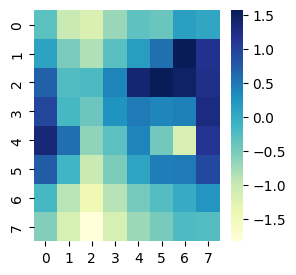

In [45]:
labels = labels_val_all[:,-1]

f = plt.figure(figsize=(3,3))
ones = np.ones((len(np.reshape(k_all_orig, (-1)))))
clust_matr1 = np.zeros(som_dim[0] * som_dim[1])

min_s1 = np.inf
for i in range(som_dim[0] * som_dim[1]):
    # Mean of labels at that cell
    s1 = np.sum(
        labels[np.where(np.reshape(k_all_orig, (-1)) == i)]
    ) / np.sum(ones[np.where(np.reshape(k_all_orig, (-1)) == i)])
    
    if s1 < min_s1:
        min_s1 = s1
    
    clust_matr1[i] = s1

clust_matr1 = np.nan_to_num(clust_matr1, nan=min_s1)

clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))
ax = sns.heatmap(clust_matr1, cmap="YlGnBu")
plt.show()

# Transitions

In [22]:
k_all = np.reshape(k_all_orig, (-1, t_len + out_len))

In [25]:
good_idx = [ 9705, 19268,  8812]
bad_idx = [ 7680, 22484, 21935]

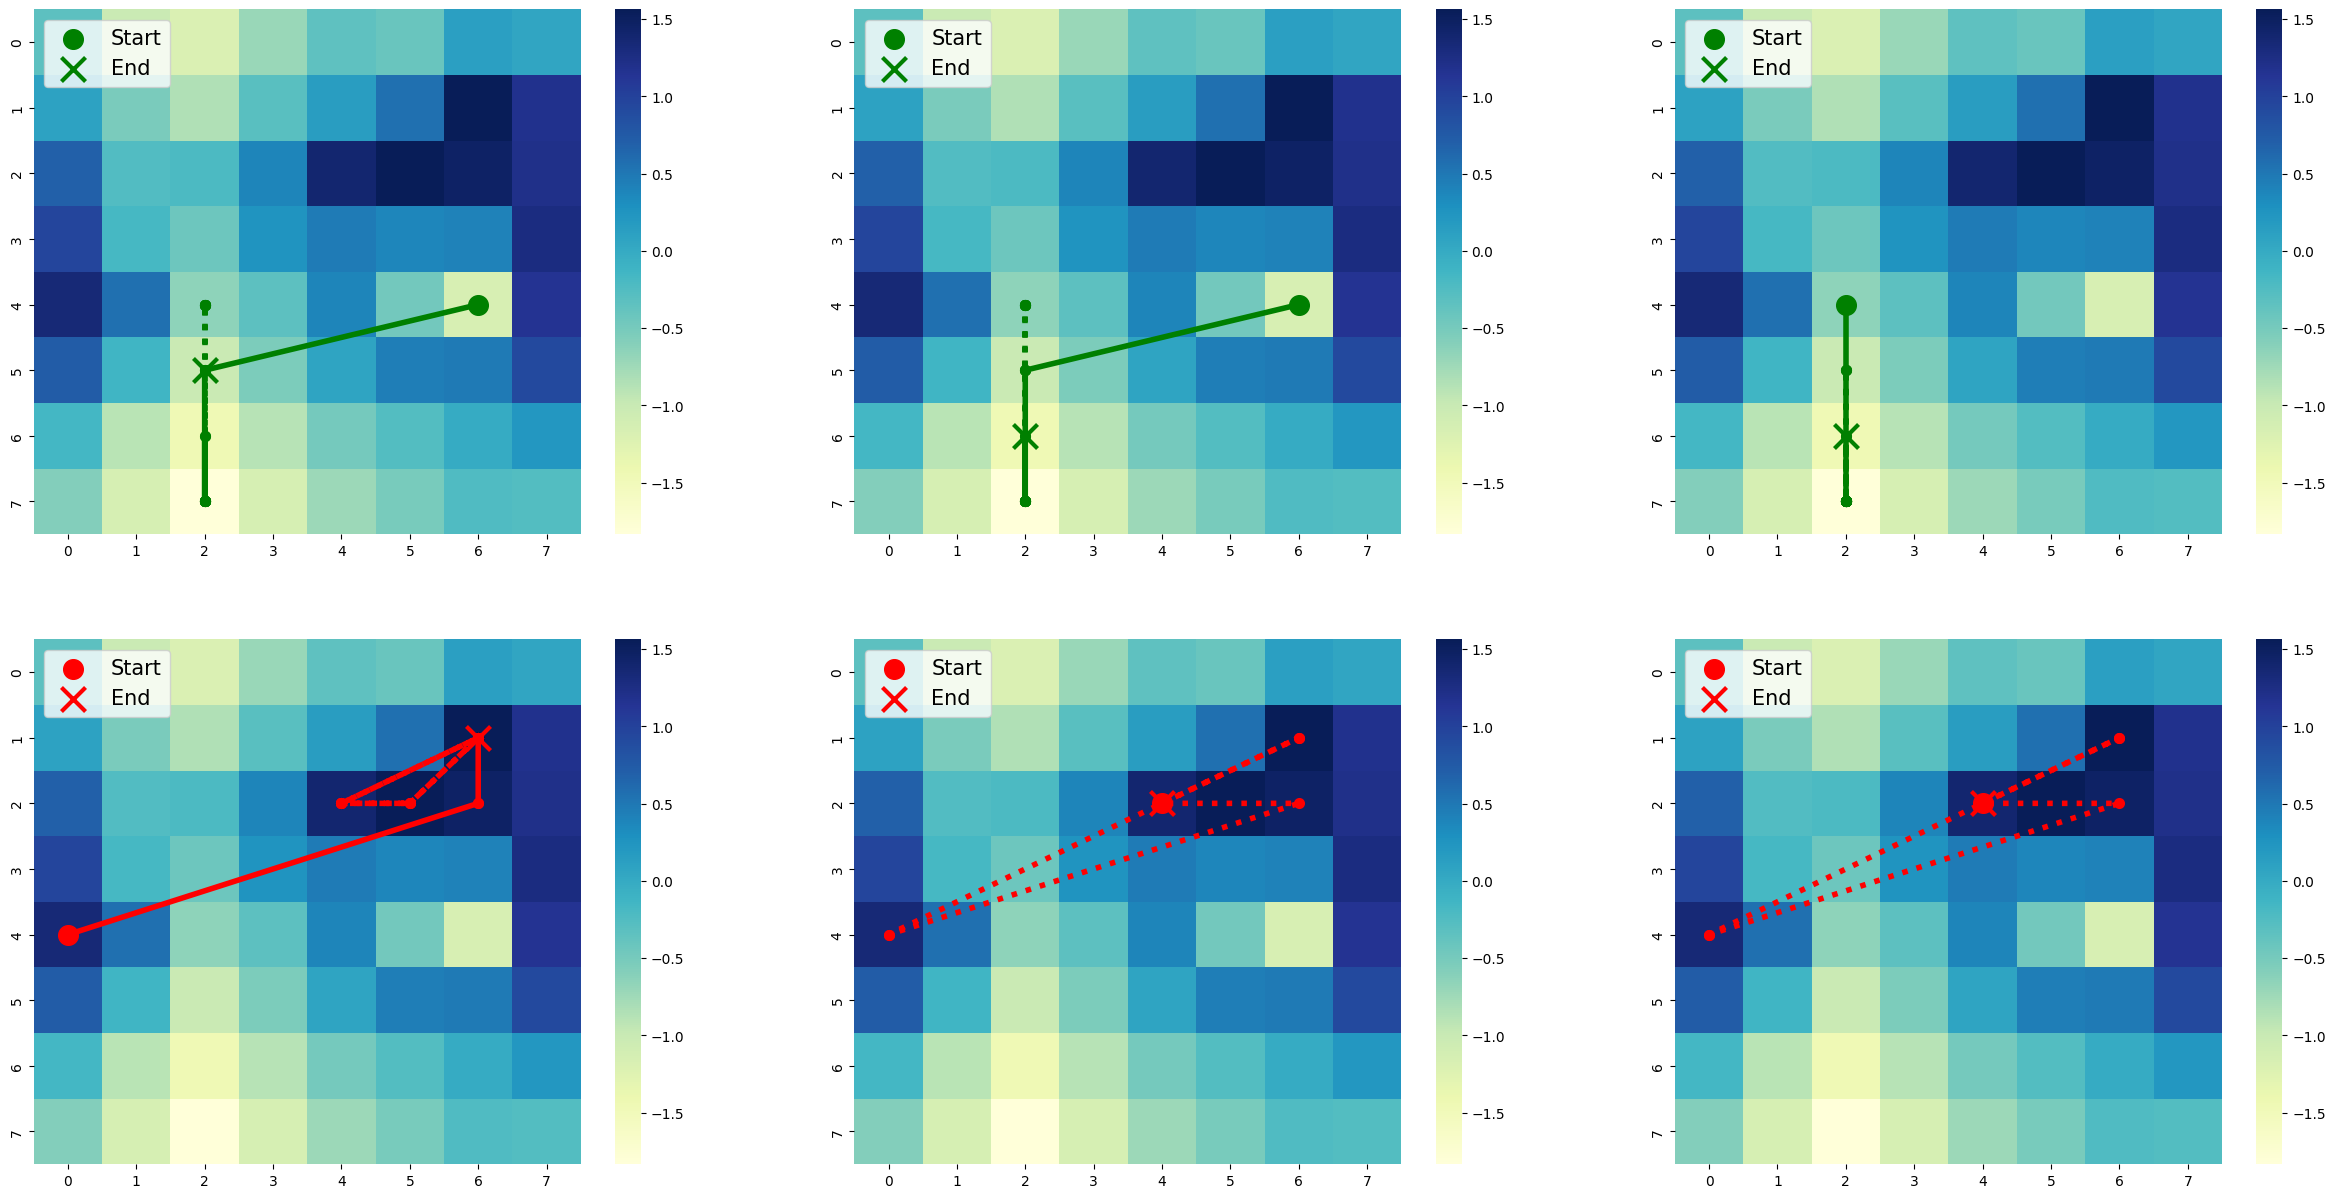

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(30, 15)) 

clust_matr1 = np.zeros(som_dim[0] * som_dim[1])

min_s1 = np.inf
for i in range(som_dim[0] * som_dim[1]):
    s1 = np.sum(
        labels[np.where(np.reshape(k_all, (-1)) == i)]
    ) / np.sum(ones[np.where(np.reshape(k_all, (-1)) == i)])
    
    if s1 < min_s1:
        min_s1 = s1
    
    clust_matr1[i] = s1

clust_matr1 = np.nan_to_num(clust_matr1, nan=min_s1)
clust_matr1 = np.reshape(clust_matr1, (som_dim[0], som_dim[1]))

it = 0
for t in np.concatenate([good_idx, bad_idx]):
    if it >= len(good_idx):
        c = "r"
    else:
        c = "g"

    cc = it % 3
    rr = it // 3
    
    g = sns.heatmap(clust_matr1, cmap="YlGnBu", ax=ax[rr][cc])
    
    k_1_all = [ii + 0.5 for ii in list(k_all[t] // som_dim[1])]
    k_2_all = [jj + 0.5 for jj in list(k_all[t] % som_dim[1])]
    
    # k_1 = k_1_all
    # k_2 = k_2_all
    
    k_1_before = k_1_all[max_n_step - 5 : max_n_step + 1]
    k_2_before = k_2_all[max_n_step - 5 : max_n_step + 1]
    
    ax[rr][cc].plot(k_2_before[:], k_1_before[:], color=c, linewidth=4)
    
    k_1 = k_1_all[max_n_step : ]
    k_2 = k_2_all[max_n_step : ]
    
    ax[rr][cc].plot(k_2[:], k_1[:], color=c, linewidth=4, linestyle=":")
    
    # Mark start
    ax[rr][cc].scatter(k_2_before[0], k_1_before[0], color=c, s=200, label="Start")
    
    # Mark path
    ax[rr][cc].scatter(k_2_before[1:-1], k_1_before[1:-1], color=c, linewidth=5, marker='.')
    ax[rr][cc].scatter(k_2[1:-1], k_1[1:-1], color=c, linewidth=5, marker='.')
    
    # Mark end
    ax[rr][cc].scatter(k_2[-1], k_1[-1], color=c, s=300, linewidth=3, marker='x', label='End')
    
    # Get legend
    ax[rr][cc].legend(loc=2, prop={'size': 15})
    
    # ax[rr][cc].tick_params(axis='both', which='major', labelsize=20)
    # ax[rr][cc].tick_params(axis='both', which='minor', labelsize=20)
    
    it +=1
    
plt.show()

---
<br> 

# Explainability

## SHAP values

In [18]:
def model_cluster_inference(input_data):
    # Set Configurations
    modelpath = "../models/{}/{}".format(ex_name, ex_name)
    # trans_mat_size = trans_mat_size
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(modelpath + ".meta")
        saver.restore(sess, modelpath)
        
        graph = tf.get_default_graph()
        
        k = graph.get_tensor_by_name("k/k:0")
        x = graph.get_tensor_by_name("inputs/x:0")
        x_trans_mat = graph.get_tensor_by_name("x_trans_mat_inputs/x_trans_mat:0")
        
        ts_data = np.expand_dims(input_data[:, trans_mat_size:], axis=0 )
        trans_mat_x_data = np.expand_dims(input_data[:, :trans_mat_size], axis=0 )
        
        k_all = []
        f_dic = {x: ts_data, x_trans_mat:trans_mat_x_data}
        k_all = sess.run(k, feed_dict=f_dic)

    return k_all

In [19]:
input_data = np.reshape(data_train_full, (-1, data_train_full.shape[2]))
k_all = model_cluster_inference(input_data)

2023-09-28 18:31:23.743134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 18:31:23.749757: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-09-28 18:31:23.751195: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [1]:
class_explanations = []
for class_label in np.unique(k_all):
    print("class_label:", class_label)
    class_mask = (k_all == class_label)
    filtered_input = input_data[class_mask]    
    sampled_input = filtered_input[np.random.choice(filtered_input.shape[0], 10, replace=False)]

    explainer = shap.Explainer(model_cluster_inference, sampled_input)
    shap_values = explainer.shap_values(sampled_input)
    class_explanations.append(shap_values)
    
# Save the shapley values.
class_explanations = np.array(class_explanations)


### Cluster Dict

In [31]:
# Generate the feature importance for each cluster
cluster_dict = {
    i: f"Transition-{i}" for i in range(0, n_clusters)
}

cluster_dict.update({
    n_clusters + 0: "Visibility",
    n_clusters + 1: "DryBulbFarenheit",
    n_clusters + 2: "DryBulbCelsius",
    n_clusters + 3: "WetBulbFarenheit",
    n_clusters + 4: "DewPointFarenheit",
    n_clusters + 5: "DewPointCelsius",
    n_clusters + 6: "RelativeHumidity",
    n_clusters + 7: "WindSpeed",
    n_clusters + 8: "WindDirection",
    n_clusters + 9: "StationPressure",
    n_clusters + 10: "Altimeter",
    n_clusters + 11: "WetBulbCelsius",
})    

In [33]:
class_explanations_new = class_explanations

In [35]:
cluster_feat_imp = {} # dict of key="cluster_id", values="most_imp_feature_name"

for i in range(len(class_explanations_new)):
    sv_cls = class_explanations_new[i]
    if np.isnan(sv_cls).all():
        cluster_feat_imp[i] = np.nan
        continue
        
    mean_sv = np.mean(sv_cls[:, trans_mat_size:], axis=0)
    # Remove heatmap feature
    mean_sv = mean_sv[:-1]
    most_imp_feature = np.abs(mean_sv).argmax()
    cluster_feat_imp[i] = trans_mat_size + most_imp_feature

## End-to-end explainability

In [31]:
train_gen = batch_generator(
    data_train, 
    endpoints_total_train, 
    batch_size, 
)

In [32]:
def z_dist_flat(z_e, embeddings):
    """Computes the distances between the encodings and the embeddings."""
    # som_dim = som_dim
    # latent_dim = latent_dim
    emb = np.reshape(embeddings, (som_dim[0]*som_dim[1], -1))
    z = np.reshape(z_e, (z_e.shape[0], 1, latent_dim))
    z = np.tile(z, [1,som_dim[0]*som_dim[1], 1])
    z_dist = np.square(z-emb)
    z_dist_red = np.sum(z_dist, axis=-1)
    return z_dist_red

## Run Model to get attention weights and `k_all_exp`

In [33]:
%%time

from tqdm.notebook import tqdm, trange

num_batches = len(data_train) // batch_size
print("num_batches", num_batches)

tf.reset_default_graph()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(modelpath + ".meta")
    saver.restore(sess, modelpath)
    
    graph = tf.get_default_graph()
    
    k = graph.get_tensor_by_name("k/k:0")
    x = graph.get_tensor_by_name("inputs/x:0")
    c = graph.get_tensor_by_name("conditions/c:0")
    z_e = graph.get_tensor_by_name("z_e_sample/z_e:0")
    next_z_e = graph.get_tensor_by_name("prediction/next_z_e:0")
    embeddings = graph.get_tensor_by_name("embeddings/embeddings:0")
    z_p = graph.get_tensor_by_name('reconstruction_e/decoder/z_e:0')
    is_training = graph.get_tensor_by_name("is_training/is_training:0")
    z_e_p = graph.get_tensor_by_name("prediction/next_state/input_lstm:0")
    init_1 = graph.get_tensor_by_name("prediction/next_state/init_state:0")
    state1 = graph.get_tensor_by_name("prediction/next_state/next_state:0")
    concat_x_c = graph.get_tensor_by_name("concatenated_inputs/concat_x_c:0")
    x_trans_mat = graph.get_tensor_by_name("x_trans_mat_inputs/x_trans_mat:0")
    y_trans_mat = graph.get_tensor_by_name("y_trans_mat_inputs/y_trans_mat:0")
    attention_weights = graph.get_tensor_by_name("prediction/next_state/attention_weights:0")
    
    #############################################################################
    #  I. Evaluating whole training data to generate heat map cluster matrix    #
    #############################################################################

    # -------------------------------------------- #
    # 1. Find all k_all of the full training data  #
    # -------------------------------------------- #
    print("Step-1")
    num_batches = len(data_train) // batch_size
    training_dic = {
        is_training: False,
        z_e_p: np.zeros((max_n_step, len(data_train), latent_dim)),
        init_1: np.zeros((2, batch_size, lstm_dim)),
        z_p: np.zeros((max_n_step * len(data_train), latent_dim + c_dim)),
    }
    k_all = []
    labels_all = []
    for i in trange(num_batches):
        batch_data, batch_labels, ii = next(train_gen)

        # Added for CVAE
        batch_ts_data = batch_data[:, :, trans_mat_size:]
        batch_trans_mat_x = batch_data[:, :, :trans_mat_size]
        batch_trans_mat_y = batch_labels[:, :, :trans_mat_size]
        labels_all.extend(batch_labels)

        batch_conditions = np.zeros((batch_ts_data.shape[0], max_n_step, c_dim))
        batch_concat_x_c = np.concatenate((batch_ts_data, batch_conditions), axis=2)
        f_dic = {
            x: batch_ts_data,
            x_trans_mat: batch_trans_mat_x,
            y_trans_mat: batch_trans_mat_y,
            c: batch_conditions,
            concat_x_c: batch_concat_x_c,
        }
        k_all.extend(sess.run(k, feed_dict=f_dic))

    k_all = np.array(k_all)
    k_all = k_all.reshape((-1, max_n_step))
    labels_all = np.array(labels_all)
    labels_all = np.reshape(labels_all, (-1, labels_all.shape[-1]))
    
    ######################################################################
    #  II. Evaluating whole validation data and generating all arrays    #
    ######################################################################
    print("Step-2")
    num_batches = len(data_train) // batch_size
    total_val_size = num_batches * batch_size
    training_dic = {
        is_training: True,
        z_e_p: np.zeros((max_n_step, len(data_train), latent_dim)),
        init_1: np.zeros((2, batch_size, lstm_dim)),
        z_p: np.zeros((max_n_step * len(data_train), latent_dim + c_dim)),
    }

    k_all = []
    z_e_all = []
    for i in trange(num_batches):
        batch_val_data, batch_val_labels, ii = next(train_gen)

        # Added for CVAE
        batch_val_ts_data = batch_val_data[:, :, trans_mat_size:]
        batch_val_trans_mat_x = batch_val_data[:, :, :trans_mat_size]
        batch_val_trans_mat_y = batch_val_labels[:, :, :trans_mat_size]

        batch_conditions = np.zeros((batch_val_ts_data.shape[0], max_n_step, c_dim))
        batch_concat_x_c = np.concatenate(
            (batch_val_ts_data, batch_conditions), axis=2
        )
        f_dic = {
            x: batch_val_ts_data,
            x_trans_mat: batch_val_trans_mat_x,
            y_trans_mat: batch_val_trans_mat_y,
            c: batch_conditions,
            concat_x_c: batch_concat_x_c,
        }

        k_all.extend(sess.run(k, feed_dict=f_dic))
        z_e_all.extend(sess.run(z_e, feed_dict=f_dic))

    z_e_all = np.array(z_e_all)
    k_all = np.array(k_all)

    z_e_all = z_e_all.reshape((-1, max_n_step, latent_dim))
    k_all = k_all.reshape((-1, max_n_step))

    #####################################################################################
    #  III. Generate embeddings for train data till (max_n_step - num_pred) step        #
    #####################################################################################
    print("Step-3")
    embeddings = sess.run(
        embeddings, feed_dict={x: data_val[:, :max_n_step, trans_mat_size:]}
    )
    embeddings = np.reshape(embeddings, (-1, latent_dim))
    
    z_e_o = z_e_all[:, :max_n_step, :]
    k_o = k_all[:, :max_n_step]
    next_z_e_o = []
    state1_o = []
    attention_weights_list = []
    attention_weights_for_all_at_t = []
    
    for i in trange(num_batches):
        batch_val_data, _, ii = next(train_gen)
        batch_val_data = batch_val_data[:, :max_n_step, :]

        # Added for CVAE
        batch_val_ts_data = batch_val_data[:, :, trans_mat_size:]
        batch_val_trans_mat_x = batch_val_data[:, :, :trans_mat_size]
        batch_conditions = np.zeros((batch_val_ts_data.shape[0], max_n_step, c_dim))
        batch_concat_x_c = np.concatenate(
            (batch_val_ts_data, batch_conditions), axis=2
        )
        f_dic = {
            x: batch_val_ts_data,
            x_trans_mat: batch_val_trans_mat_x,
            c: batch_conditions,
            concat_x_c: batch_concat_x_c,
        }
        f_dic.update(training_dic)

        next_z_e_o.extend(sess.run(next_z_e, feed_dict=f_dic))
        attention_weights_for_all_at_t.extend(
            sess.run(attention_weights, feed_dict=f_dic)
        )

        if i == 0:
            state1_o = sess.run(state1, feed_dict=f_dic)
        else:
            state1_o = np.concatenate(
                [state1_o, sess.run(state1, feed_dict=f_dic)], axis=1
            )
    next_z_e_o = np.array(next_z_e_o)
    state1_o = np.array(state1_o)
    next_z_e_o_all = np.reshape(next_z_e_o, (-1, max_n_step, latent_dim))
    k_next = np.argmin(
        z_dist_flat(next_z_e_o[:, -1, :], embeddings), axis=-1
    )
    k_o = np.concatenate([k_o, np.expand_dims(k_next, 1)], axis=1)

    # Added for attention explainations.
    attention_weights_for_all_at_t = np.array(attention_weights_for_all_at_t)
    attention_weights_list.append(attention_weights_for_all_at_t)
    attention_weights_list = np.array(attention_weights_list)
    
    ###########################################################################
    #  IV. Updated pred with sliced data and embeddings for each timestamp.   #
    ###########################################################################
    print("Step-4")
    for i in trange(num_pred - 1):
        inp = data_train_full[:total_val_size, i : (max_n_step + i), trans_mat_size:]
        inp_trans = data_train_full[
            :total_val_size, i : (max_n_step + i), :trans_mat_size
        ]

        batch_conditions = np.zeros((inp.shape[0], max_n_step, c_dim))
        batch_concat_x_c = np.concatenate((inp, batch_conditions), axis=2)

        f_dic = {x: inp, x_trans_mat: inp_trans}
        val_dic = {
            is_training: False,
            z_e_p: next_z_e_o,
            init_1: state1_o,
            z_p: np.zeros((max_n_step * len(inp), latent_dim + c_dim)),
            c: batch_conditions,
            concat_x_c: batch_concat_x_c,
        }
        f_dic.update(val_dic)
        next_z_e_o = sess.run(next_z_e, feed_dict=f_dic)
        state1_o = sess.run(state1, feed_dict=f_dic)
        k_next = np.argmin(
            z_dist_flat(next_z_e_o[:, -1, :], embeddings), axis=-1
        )
        k_o = np.concatenate([k_o, np.expand_dims(k_next, 1)], axis=1)

        # Storing Attention Weights for each prediction.
        attention_weights_o = sess.run(attention_weights, feed_dict=f_dic)
        # print("attention_weights_o.shape", attention_weights_o.shape)
        attention_weights_list = np.concatenate(
            [attention_weights_list, np.expand_dims(attention_weights_o, 0)], axis=0
        )
        # print("attention_weights_list.shape", attention_weights_list.shape)

        next_z_e_o_all = np.concatenate(
            [
                next_z_e_o_all,
                np.reshape(
                    next_z_e_o[:, -1, :],
                    (
                        next_z_e_o[:, -1, :].shape[0],
                        1,
                        next_z_e_o[:, -1, :].shape[1],
                    ),
                ),
            ],
            axis=1,
        )
        next_z_e_o = next_z_e_o_all[:, i + 1 :, :]

    k_o_pred = k_o[:, max_n_step:]
    
k_all_exp = k_all.copy()

num_batches 91
Step-1


  0%|          | 0/91 [00:00<?, ?it/s]

Step-2


  0%|          | 0/91 [00:00<?, ?it/s]

Step-3


  0%|          | 0/91 [00:00<?, ?it/s]

Step-4


  0%|          | 0/23 [00:00<?, ?it/s]

CPU times: user 2h 32min 35s, sys: 20min 3s, total: 2h 52min 39s
Wall time: 12min 41s


## Trajectories

In [61]:
# Player ID - select a player/trajectory index
# p_id = good_idx[1]
p_id = bad_idx[0]
print("Selected player ID =", p_id)

# Time step attended to the maximum
player_att_map = attention_weights_list[-1, p_id, :, -1]
t_id = np.argmax(player_att_map[:-1])
print("Time Step attended to the maximum =", t_id)

# Which cluster does the most attended time-step of the feature belong to?
# What is the most important feature of that cluster?
c_id = k_all[p_id, t_id] # cluster allocation at that time step 
f_id = cluster_feat_imp[c_id] # most important feature according to SHAP for that cluster
f_name = cluster_dict[f_id] # name of the feature
print("Feature Index =", f_id)
print("Feature Name =", f_name)

Selected player ID = 7680
Time Step attended to the maximum = 0
Feature Index = 5
Feature Name = DryBulbFarenheit


In [74]:
target_feature = trans_mat_size + 12 - 1 
alt_feature = cluster_feat_imp[k_all[p_id, np.argmin(player_att_map[:-1])]]

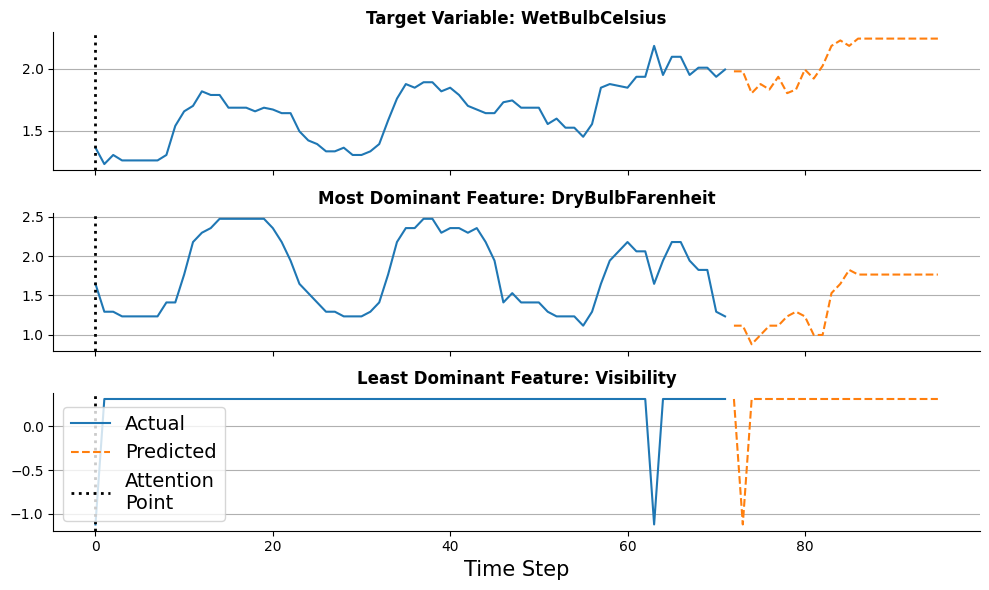

In [76]:
fig, ax = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

y_before = data_train_full[p_id, : max_n_step, target_feature]
y_after = data_train_full[p_id, max_n_step :, target_feature]

ax[0].plot(y_before, linestyle="solid", label="Actual")
ax[0].plot(range(max_n_step, max_n_step + num_pred), y_after, linestyle="dashed", label="Predicted")
ax[0].axvline(t_id, linestyle="dotted", color="black", linewidth=2, label="Attention\nPoint")
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].grid(axis="y")
ax[0].set_title("Target Variable: " + cluster_dict[target_feature], fontweight="bold")

y_before = data_train_full[p_id, : max_n_step, f_id]
y_after = data_train_full[p_id, max_n_step :, f_id]

ax[1].plot(y_before, linestyle="solid", label="Actual")
ax[1].plot(range(max_n_step, max_n_step + num_pred), y_after, linestyle="dashed", label="Predicted")
ax[1].axvline(t_id, linestyle="dotted", color="black", linewidth=2, label="Attention\nPoint")
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].grid(axis="y")
ax[1].set_title("Most Dominant Feature: " + cluster_dict[f_id], fontweight="bold")

y_before = data_train_full[p_id, : max_n_step, alt_feature]
y_after = data_train_full[p_id, max_n_step :, alt_feature]

ax[2].plot(y_before, linestyle="solid", label="Actual")
ax[2].plot(range(max_n_step, max_n_step + num_pred), y_after, linestyle="dashed", label="Predicted")
ax[2].axvline(t_id, linestyle="dotted", color="black", linewidth=2, label="Attention\nPoint")
ax[2].spines[['right', 'top']].set_visible(False)
ax[2].grid(axis="y")
ax[2].set_title("Least Dominant Feature: " + cluster_dict[alt_feature], fontweight="bold")

_ = plt.xlabel("Time Step", fontsize=15)
_ = plt.tight_layout()
_ = plt.legend(loc="lower left", prop={"size": 14})